In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
# from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions

##### References: 
- https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf
- https://brendanhasz.github.io/2018/12/03/tfp-regression


##### Hierarchical bayesian models
- https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb

# Create a dataset

## Dataset 1: from the tutorial

In [3]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

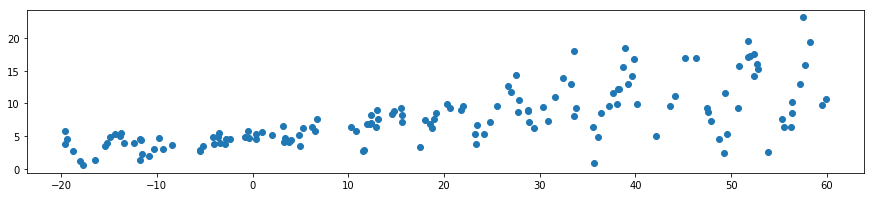

In [4]:
plt.figure(figsize = (15,3))
plt.scatter(x,y)
plt.show()

## Dataset 2: simple linear expression

In [5]:
x = np.linspace(0,10,100)
xm = x[...,np.newaxis]
# y = 1+30*np.random.rand(100)*x
y = 1+3*x+20*np.random.rand(100)

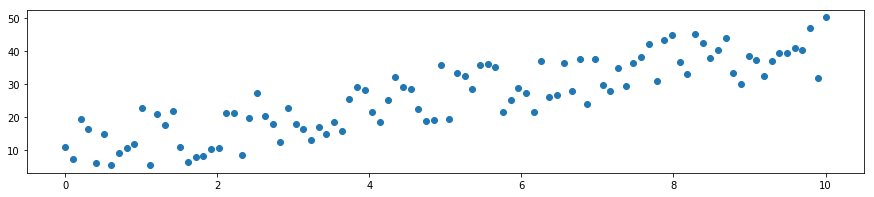

In [6]:
plt.figure(figsize = (15,3))
plt.scatter(x,y)
plt.show()

# Simple linear regression with Tensorflow

In [115]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

model.compile(optimizer = "adam",loss = "mse")

In [116]:
model.fit(xm,y,epochs = 4000,verbose = False)

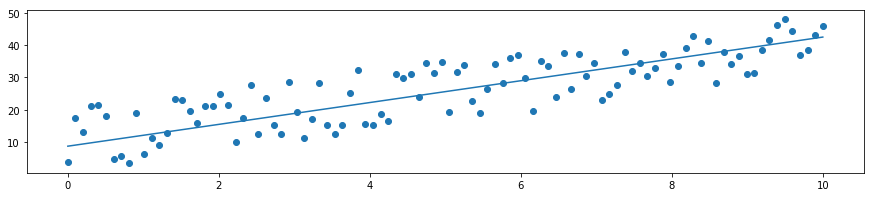

In [117]:
plt.figure(figsize = (15,3))
plt.plot(x,model.predict(x))
plt.scatter(x,y)
plt.show()

In [118]:
model.get_weights()

[array([[3.369884]], dtype=float32), array([8.785047], dtype=float32)]

# Regression with Prior

In [120]:
model2 = tf.keras.Sequential([
    tfp.layers.DenseFlipout(1,bias_prior_fn = lambda a,b,c,d,e : tfd.Normal(loc=10,scale=1))
])

model2.compile(optimizer = "adam",loss = "mse")

In [121]:
model2.fit(xm,y,epochs = 200,verbose = False)

NotImplementedError: No KL(distribution_a || distribution_b) registered for distribution_a type Independent and distribution_b type Normal

In [60]:
model2.predict(x).shape

(150, 1)

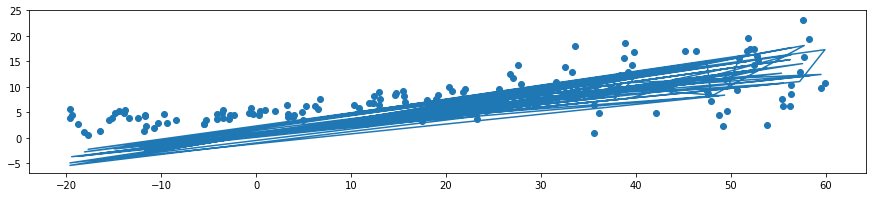

In [59]:
plt.figure(figsize = (15,3))
plt.plot(x,model2.predict(x))
plt.scatter(x,y)
plt.show()

# GLM with tfp

In [24]:
coefs,lr,is_conv,num_iter = tfp.glm.fit(model_matrix=x,response=y,
            model = tfp.glm.Normal()
           )

In [26]:
coefs

<tf.Tensor: id=7047, shape=(1,), dtype=float64, numpy=array([0.24387781])>

In [29]:
num_iter

<tf.Tensor: id=7074, shape=(), dtype=int32, numpy=2>